# **Name:** Subhadeep Chaudhuri | **Roll no.** : 19i190010

# **Question 7:** 

- **Algorithm considered:** EXP3
-**Settings considered:** Stochastic (Bernoulli) and Deterministic
- **Number of arms:** 2
- **Horizon:** $10^5$

In [108]:
###########################################
## Importing the necessary packages
###########################################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import scipy.stats as ss
import copy
from tqdm import tqdm
from collections import Counter

In [109]:
###############################
## Different algorithm types
###############################
EXP3 = 1
EXP3_P = 2
EXP3_IX = 3

######################################
## Different loss generation setting
######################################
stochastic = 4
deterministic = 5

In [110]:
#############################################################################################
## Method to compute the first term in the expression of pseudo-regret
## Input: Setting chosen - stochastic/deterministic, the arms selected in each round till time T
#############################################################################################
def mean_losses(setting, chosen_arms):
    if setting  == stochastic:
        means_array = np.array([0.5, 0.55])
        observed_means = np.array([means_array[i] for i in chosen_arms])
        return np.sum(observed_means) 
    
    elif setting == deterministic:                   
        means_array_slot1 = np.array([0,1])
        means_array_slot2 = np.array([1,0])
        arms_slot_1 = chosen_arms[:int(len(chosen_arms)/4)]
        arms_slot_2 = chosen_arms[int(len(chosen_arms)/4):]
        observed_means_slot1 = np.array([means_array_slot1[i] for i in arms_slot_1])
        observed_means_slot2 = np.array([means_array_slot2[i] for i in arms_slot_2])
        
        return np.sum(observed_means_slot1) + np.sum(observed_means_slot2)
    else:
        raise ValueError('Invalid input for the bandit setting. Check')

In this block, we define the main implementation. It is such that it computes the regret for the algorithm depending on additional arguments that states the algorithm type and the setting considered. (We re-use the code written in Question 2, so we only take EXP3 as argument of the algorithm type.)

- **Inputs to the algorithm:**
> - **Algorithm type**: argument corresponding to algorithm type. Can be EXP3, EXP3-P or EXP3-IX. Here, we will be using only EXP3 in this question.
> - **Setting**: Either "stochastic" or "deterministic" depending on the generation of loss.  
> - **Horizon** $T$, 
> - **Number of arms** $k$
> - $c$ which will be used to calculate the learning rate $\eta = c\sqrt{\frac{2log(d)}{kT}}$

- We create a loss matrix of shape $T \times d$, where the $i^{th}$ row denotes the losses of the $k$ arms at time round $i$. We create the entire loss matrix at once to reduce complexity of the algorithm.
- **Output:** Regret of the algorithm, $R(T)$ 

In [111]:
################################################
## Implementing the main algorithm
## Algorithm choices: EXP3, EXP3_P, EXP3_IX,  Setting: stochastic or deterministic
## We will be using only EXP3 in this problem
################################################

def algorithm(algo_type, setting, T, k, c):
    
    ## Creating a loss matrix of size (T x d)
    ## i-th row denoting loss of all experts in i-th round
    ## Depends on the setting input. Loss generated either deterministically or stochastically  
    #######################################################
    if setting == deterministic:
        rewards_arm1 = [1 if i <= (T/4) else 0 for i in range(T)]
        rewards_arm2 = [1 if i > (T/4) else 0 for i in range(T)]
        loss = np.subtract(np.ones((T,2)), np.array([rewards_arm1, rewards_arm2]).T)
    elif setting == stochastic:
        loss = np.random.binomial(n=1, p = (0.50, 0.55), size = (T,k))
    else:
        raise ValueError('Invalid input for the bandit setting. Check')
    
    ## Initializing and creating necessary variables
    #######################################################
    eta = c*np.sqrt(2*np.log(k)/(k*T))     ## Learning rate eta 
    total_loss = 0                         ## Variable to store total cost incurred throughout
    L = np.zeros(k)                        ## Array to store L_hat. Gets updated in each round
    arms = [i for i in range(k)]           ## List of indices corresponding to each of the K arms
    chosen_arms = []
    if algo_type == EXP3_P:                ## Requirements for EXP3_P
        gamma = k*eta  
        beta = eta
    elif algo_type == EXP3_IX:             ## Requirements for EXP3_IX
        gamma = eta/2
    
    ## Iteration over time. Main loop of the algorithm
    #######################################################
    for t in range(T):
        if algo_type == EXP3:                                  ############### Implementation for Exp3 algorithm ###############
            l_t_hat = np.zeros(k)
            p_t = np.divide(np.exp(-eta*L), np.sum(np.exp(-eta*L)))         ## Probability vector
            I_t = np.random.choice(arms, p = p_t)                           ## Selection of arm I_t in round t w.ith associated probability P_t 
            l_t = loss[t][I_t]                                              ## Loss observed due to selection of arm I_t
            total_loss += l_t                                               ## Summing up observed losses over rounds
            l_t_hat[I_t] = l_t/p_t[I_t]
            L += l_t_hat
            chosen_arms.append(I_t)
        elif algo_type == EXP3_P:                            ################# Implementation for Exp3_P algorithm ###############
            l_t_hat = np.zeros(k)
            p_t = np.multiply((1-gamma),np.divide(np.exp(-eta*L), np.sum(np.exp(-eta*L)))) + (gamma/k)
            I_t = np.random.choice(arms, p = p_t)
            l_t = loss[t][I_t]
            total_loss += l_t
            l_t_hat[I_t] = (l_t + beta)/p_t[I_t]
            L += l_t_hat
            chosen_arms.append(I_t)
        elif algo_type == EXP3_IX:                           ################# Implementation for Exp3_IX algorithm ###############
            l_t_hat = np.zeros(k)
            # p_t = np.multiply((1-gamma),np.divide(np.exp(-eta*L), np.sum(np.exp(-eta*L)))) 
            p_t = np.divide(np.exp(-eta*L), np.sum(np.exp(-eta*L)))
            I_t = np.random.choice(arms, p = p_t)
            l_t = loss[t][I_t]
            total_loss += l_t
            l_t_hat[I_t] = l_t /(p_t[I_t]+gamma)
            L += l_t_hat
            chosen_arms.append(I_t)
    # print(Counter(chosen_arms))
    total_expected_loss = mean_losses(setting, chosen_arms)
    if setting == stochastic:
        best_arm_loss = np.min([T*0.5, T*0.55]) 
        regret = total_expected_loss - best_arm_loss
    else:        
        best_arm_loss = T/4
        regret = total_expected_loss - best_arm_loss
        # best_arm_loss = min(loss.sum(axis = 0)) 
        # regret = total_loss - best_arm_loss

    return regret

This method implements the desired algorithm over multiple runs. The regret obtained from each run of the algorithm are then stored in an array for further use.

In [112]:
##################################################################
## Method to call the different algorithm over multiple runs
## Algorithm choices: EXP3, EXP3_P, EXP3_IX,  Setting: stochastic or deterministic
## We will be using only EXP3 in this problem
##################################################################

def algo_over_runs(runs, *args):

    ## Checking the validity of the arguments required in weighted_majority algorithm
    #################################################################################
    if args is None:
        err_msg = 'Arguments are missing. Check again!'
        raise ValueError(err_msg)
    elif len(args) < 5 :
        err_msg = 'Minimum arguments not given. Check again!'
        raise ValueError(err_msg)
    else:
        algo_type = args[0]
        setting = args[1]
        T = args[2]
        k = args[3]
        c = args[4]

    ## Storing the regret obtained for each run in an array
    #######################################################
    regret_array = np.zeros(runs)
    for i in range(runs):
        regret_array[i] = algorithm(algo_type, setting, T, k, c)     ## Looping over runs and storing the regret in each run
    
    return regret_array

This method is used to obtain the average regrets over multiple runs along with 95% confidence intervals for different choices of $c$ i.e. for different learning rates $\eta$ corresponding to the desired algorithm type.

In [113]:
###################################################################################
## Method to store the mean regret for each choice of eta for the chosen algorithm 
## Algorithm choices: EXP3, EXP3_P, EXP3_IX,  Setting: stochastic or deterministic
## We will be using only EXP3 in this problem
###################################################################################

def algo_over_all(runs, algo_type, setting, T, k, c_array):

    ## Calculating the average regret over many runs for each eta
    ## 95% CI are to be created. So we store the error terms as well
    ##################################################################
    mean_regret_array = []
    regret_error = []
    for i in tqdm(range(len(c_array))):                                              ## Looping over all the choices of c, i.e. different eta
        regret_array_c =  algo_over_runs(runs, algo_type, setting, T, k, c_array[i])
        mean_regret_array.append(np.mean(regret_array_c))                            ## Storing the mean regrets over multiple runs
        regret_error.append(ss.t.ppf(0.95, df = runs -1)*ss.sem(regret_array_c))     ## Storing the standard error over multiple runs for the 95% CI

    return np.array(mean_regret_array), np.array(regret_error)

This method is used to obtain the plots showing the average regrets over multiple runs along with 95% confidence intervals for different choices of $c$ i.e. for different learning rates $\eta$ corresponding to each of the algorithm types EXP3, EXP3.P and EXP3-IX.

We call each of the algorithm types using "algo_over_all" and store it in some arrays, which are then plotted. 

These are the parameters of the problem, as given in the question. We average out the regret over 50 runs, with the horizon taken as $10^5$

In [121]:
###########################################
## Parameters for the problem
###########################################
T = 100000   ## Horizon
k = 2        ## No. of experts
c_array = np.arange(0.1, 2.11, 0.2).astype(np.double).round(2)
eta_array = c_array*np.sqrt(2*np.log(k)/(k*T))      ## Eta array for all possible choices of c
runs = 50    ## No. of runs

## **Stochastic setting:**

Here, the losses will be generated as per the underlying probability distribution. The losses of the first arm are generated by Bernoulli(0.5) and the losses of the second arm by Bernoulli(0.55) distribution.

In [122]:
###########################################
## Stochastic setting with Bernoulli losses
###########################################
mean_regret_array_EXP3, regret_error_EXP3 = algo_over_all(runs, EXP3, stochastic, T, k, c_array)              ## Storing the mean regrets for EXP3 algo 

100%|██████████| 11/11 [47:59<00:00, 261.78s/it]


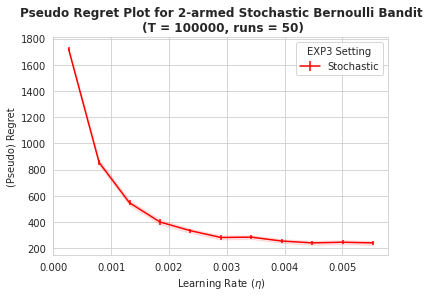

In [123]:
###############################################################
## Plotting the regret for each eta along with the 95% CI
###############################################################
plt.errorbar(eta_array, mean_regret_array_EXP3, regret_error_EXP3, color = 'red', label = 'Stochastic')
plt.fill_between(eta_array, mean_regret_array_EXP3 - regret_error_EXP3, mean_regret_array_EXP3 + regret_error_EXP3, color='red', alpha=0.1)
plt.title(f'Pseudo Regret Plot for 2-armed Stochastic Bernoulli Bandit\n (T = {T}, runs = {runs})', fontweight = 'bold')
plt.xlabel('Learning Rate ($\eta$)')
plt.ylabel('(Pseudo) Regret')
plt.legend(title = 'EXP3 Setting')
plt.show()

## **Deterministic setting:**

Here, the losses will be generated as per the deterministic setting. The rewards of the two arms are generated as per the following policy:

$
\begin{align*}
x_{t1} = \mathbb{I}\{t\leq T/4\}\\
x_{t2} = \mathbb{I}\{t > T/4\}\\
\end{align*}
$

Since our algorithm defined the regret based on the losses, we define the loss for each arm as (1 - reward observed for that arm at time $t$).

In [118]:
##############################################################
## Deterministic setting with fixed losses w.r.t. time (round)
##############################################################
mean_regret_array_determ, regret_error_determ = algo_over_all(runs, EXP3, deterministic, T, k, c_array)              ## Storing the mean regrets for EXP3 algo 


100%|██████████| 11/11 [43:22<00:00, 236.58s/it]


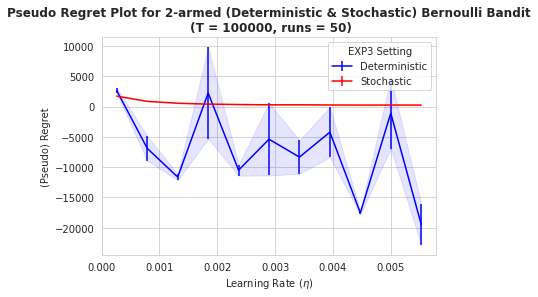

In [126]:
###############################################################
## Plotting the regret for each eta along with the 95% CI
###############################################################
plt.errorbar(eta_array, mean_regret_array_determ, regret_error_determ, color = 'blue', label = 'Deterministic')
plt.fill_between(eta_array, mean_regret_array_determ - regret_error_determ, mean_regret_array_determ + regret_error_determ, color='blue', alpha=0.1)
plt.errorbar(eta_array, mean_regret_array_EXP3, regret_error_EXP3, color = 'red', label = 'Stochastic')
plt.fill_between(eta_array, mean_regret_array_EXP3 - regret_error_EXP3, mean_regret_array_EXP3 + regret_error_EXP3, color='red', alpha=0.1)
plt.title(f'Pseudo Regret Plot for 2-armed (Deterministic & Stochastic) Bernoulli Bandit\n (T = {T}, runs = {runs})', fontweight = 'bold')
plt.xlabel('Learning Rate ($\eta$)')
plt.ylabel('(Pseudo) Regret')
plt.legend(title = 'EXP3 Setting')
plt.show()